In [58]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
path = "/content/XAUUSD.csv"
df = pd.read_csv(path)
df.columns = df.iloc[0]
df = df.drop(index=0)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')
df["Close"] = pd.to_numeric(df["Close"])
df = df[::-1].reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         622 non-null    int64         
 1   Date          622 non-null    datetime64[ns]
 2   Open          622 non-null    object        
 3   High          622 non-null    object        
 4   Low           622 non-null    object        
 5   Close         622 non-null    float64       
 6   Change(Pips)  622 non-null    object        
 7   Change(%)     622 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 39.0+ KB


In [60]:
data = df[["Close"]]
# data.set_index("Date", inplace=True)
data.head(5)

,Close
0,1786.39
1,1791.15
2,1795.68
3,1803.22
4,1803.75


In [61]:
dataset = data.values

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [63]:
train_size = int(len(dataset) * 0.7)
train, test = dataset[:train_size, 0], dataset[train_size:len(dataset), 0]

In [64]:
len(dataset), len(train), len(test)

(622, 435, 187)

In [65]:
def to_seq(data, seq_size=5):
    x, y= [], []

    for i in range(len(df) - seq_size - 1):
        if (i + seq_size) >= len(data):
            break

        window = data[i: (i + seq_size)]
        x.append(window)
        y.append(data[i + seq_size])

    return np.array(x), np.array(y)

In [66]:
seq_size = 5
X_train, y_train = to_seq(train, seq_size)
X_test, y_test = to_seq(test, seq_size)

In [67]:
len(X_train), len(y_train), len(X_test), len(y_test)

(430, 430, 182, 182)

In [68]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [69]:
# X_train = tf.convert_to_tensor(X_train)
# y_train = tf.convert_to_tensor(y_train)

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, 5)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MSE)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                17920     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    epochs=50)

Epoch 1/50
14/14 - 3s - loss: 0.1424 - val_loss: 0.1247 - 3s/epoch - 220ms/step
Epoch 2/50
14/14 - 0s - loss: 0.0141 - val_loss: 0.0048 - 81ms/epoch - 6ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0119 - val_loss: 0.0100 - 90ms/epoch - 6ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0073 - val_loss: 0.0182 - 92ms/epoch - 7ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0062 - val_loss: 0.0073 - 95ms/epoch - 7ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0049 - val_loss: 0.0059 - 99ms/epoch - 7ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0040 - val_loss: 0.0046 - 98ms/epoch - 7ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0033 - val_loss: 0.0033 - 82ms/epoch - 6ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0028 - val_loss: 0.0030 - 94ms/epoch - 7ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0025 - val_loss: 0.0023 - 91ms/epoch - 6ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0024 - val_loss: 0.0024 - 105ms/epoch - 7ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0023 - val_loss: 0.0022 - 77ms/epoch - 5ms/step
Epoch 13/50
14/14 - 0s - loss: 0.002

In [72]:
y1 = model.predict(X_train)
y_hat = model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


In [73]:
y = np.concatenate((y_train, y_test))
y = scaler.inverse_transform(np.reshape(y, (-1, 1)))
y1 = scaler.inverse_transform(y1)
y_hat_scale = scaler.inverse_transform(y_hat)

In [74]:
data = data[10:]
data["prediction"] = np.concatenate((y1.reshape((-1)), y_hat_scale.reshape((-1))))
data

<ipython-input-74-37dc546a1a78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["prediction"] = np.concatenate((y1.reshape((-1)), y_hat_scale.reshape((-1))))


,Close,prediction
10,1829.43,1801.458130
11,1811.64,1804.531250
12,1815.67,1804.968018
13,1811.17,1804.185547
14,1809.56,1803.946533
...,...,...
617,1908.76,1908.613159
618,1919.20,1904.911621
619,1917.70,1911.413330
620,1921.17,1914.240845


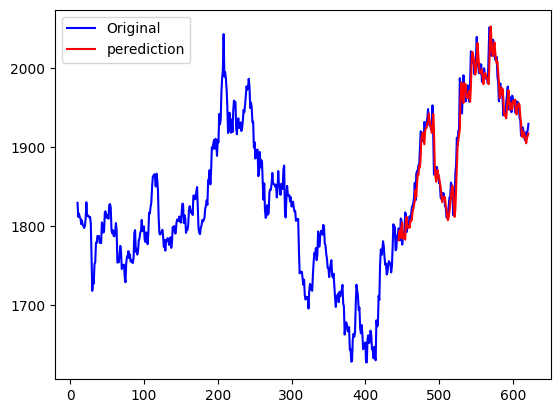

In [75]:
plt.plot(data["Close"], label="Original", color="blue")
plt.plot(data["prediction"][train_size:], label="perediction", color="red")
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


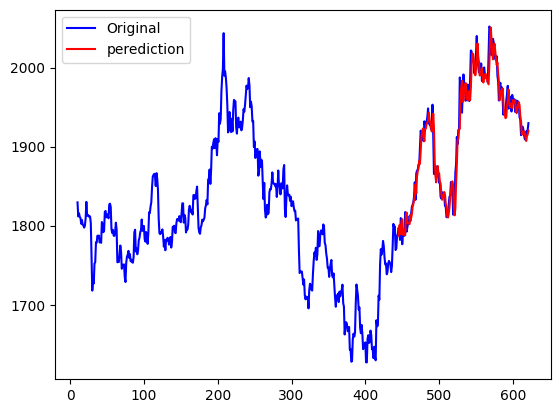

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 5), activation='relu'),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MSE)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    epochs=50)

y1 = model.predict(X_train)
y_hat = model.predict(X_test)
y = np.concatenate((y_train, y_test))
y = scaler.inverse_transform(np.reshape(y, (-1, 1)))
y1 = scaler.inverse_transform(y1)
y_hat_scale = scaler.inverse_transform(y_hat)

data["prediction2"] = np.concatenate((y1.reshape((-1)), y_hat_scale.reshape((-1))))

plt.plot(data["Close"], label="Original", color="blue")
plt.plot(data["prediction2"][train_size:], label="perediction", color="red")
plt.legend()
plt.show()

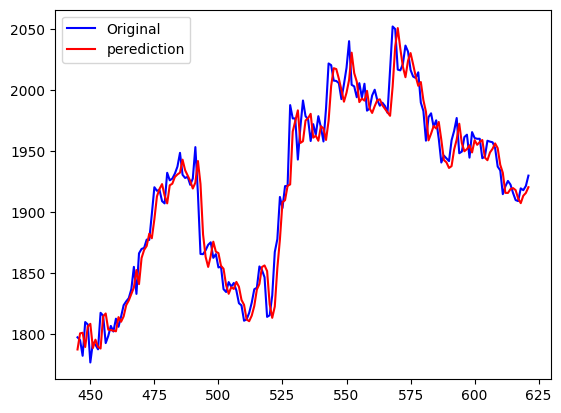

In [80]:
plt.plot(data["Close"][train_size:], label="Original", color="blue")
plt.plot(data["prediction2"][train_size:], label="perediction", color="red")
plt.legend(loc="upper left")
plt.show()